In [1]:
#import Numpy
import os
import numpy as np

# Import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline

#Now, import the FITS module inside Astropy
from astropy.io import fits

import math
import time
import numpy.ma as ma

#import package to caclulate remaining loop time 
from time import sleep
from tqdm import tqdm
from tqdm.notebook import tqdm

In [7]:
# Let's define te directory where you are with the "get current working directory" command...
work_dir = os.getcwd()
print("I am in dir %s" % work_dir)

#We can go up by using the path.dirname
main_dir =os.path.dirname(work_dir)
print("Main directory is %s" % main_dir)

#We can then define the data directory using the os.path.join command
data_dir = os.path.join(main_dir,"data/Vela")
print("data dir is %s" % data_dir)

#..and we can define some output directory with the results
results_dir = os.path.join(main_dir,"results")

#if the directory does not exist, you can create it...
if not os.path.exists(results_dir):
    os.mkdir(results_dir)
    print("Directory %s created !" % results_dir)

I am in dir /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/code
Main directory is /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r
data dir is /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/data/Vela


In [8]:
#define the input file
input_filename = os.path.join(data_dir,"Vela_3deg_100mev_gti_bary.fits")

#First, open the file and check the information in it
fits_info = fits.open(input_filename)
#fits_info1 = fits.open(input_filename1)

#...like the number of HDU, in this case 5
fits_info.info()

Filename: /home/sara/Scrivania/1magistrale/multimessenger/pulsar/experience-pulsars-Sara-a-r/data/Vela/Vela_3deg_100mev_gti_bary.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      61   ()      
  1  EVENTS        1 BinTableHDU    257   61573R x 23C   [E, E, E, E, E, E, E, E, E, D, J, J, I, 3I, 32X, 32X, I, D, E, E, E, E, E]   
  2  GTI           1 BinTableHDU     77   1751R x 2C   [D, D]   


In [9]:
#We will look at the EVENTS table (HDU=1)
table_header = fits_info[1].header
table_data = fits_info[1].data

table_data.columns

ColDefs(
    name = 'ENERGY'; format = 'E'; unit = 'MeV'
    name = 'RA'; format = 'E'; unit = 'deg'
    name = 'DEC'; format = 'E'; unit = 'deg'
    name = 'L'; format = 'E'; unit = 'deg'
    name = 'B'; format = 'E'; unit = 'deg'
    name = 'THETA'; format = 'E'; unit = 'deg'
    name = 'PHI'; format = 'E'; unit = 'deg'
    name = 'ZENITH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'EARTH_AZIMUTH_ANGLE'; format = 'E'; unit = 'deg'
    name = 'TIME'; format = 'D'; unit = 's'
    name = 'EVENT_ID'; format = 'J'
    name = 'RUN_ID'; format = 'J'
    name = 'RECON_VERSION'; format = 'I'
    name = 'CALIB_VERSION'; format = '3I'
    name = 'EVENT_CLASS'; format = '32X'
    name = 'EVENT_TYPE'; format = '32X'
    name = 'CONVERSION_TYPE'; format = 'I'
    name = 'LIVETIME'; format = 'D'; unit = 's'
    name = 'DIFRSP0'; format = 'E'
    name = 'DIFRSP1'; format = 'E'
    name = 'DIFRSP2'; format = 'E'
    name = 'DIFRSP3'; format = 'E'
    name = 'DIFRSP4'; format = 'E'
)

In [10]:
#Now convert the data to a Astropy Table object
from astropy.table import Table

evt_data = Table(table_data)
print("**Data contains %d events, this is the number of photons" % len(evt_data))

Nph = len(evt_data)

#convert data time in array
data_time = np.asarray(evt_data['TIME'])

**Data contains 61573 events, this is the number of photons


In [11]:
#-------------------DEFINE FUNCTION AND PARAMETERS FOR SCAN---------------------

#define the epoch as the central time of time intervall (T=54730-54820 MJD)
t0 = (254880002 + 247104001) /2

#define T as the difference of time intervall in MET
T = (254880002 - 247104001)

#define the initial values of f0,f1 and the spacing 
f_0start = 11.1903
f_1start = -1.55907e-11
df_0 = 0.15/T   #or 1/T 
df_1 = 0.3/T**2    #or 2/T**2

#define the array of f0,f1 to use for the scan
stepf0 = 1000
stepf1 = 50

f_0 = np.arange(f_0start-(stepf0/2)*df_0,f_0start+(stepf0/2)*df_0, df_0)
f_1 = np.arange(f_1start-(stepf1/2)*df_1,f_1start+(stepf1/2)*df_1, df_1)

print('**The number of step for f0 is %.0f, instead for f1 is %.0f' %(len(f_0), len(f_1)))

#define the number of harmonics
n = 8

#define function to calculate pulse phases
def Phi(f0,f1, time):
    phi = f0 * (time - t0) + f1/2 * (time - t0)**2
    frac_phi, int_phi = np.modf(phi)   #take the fractional part
    frac_phi[frac_phi<0] = frac_phi[frac_phi<0] + 1   #if phase is negative report it in [0,1] intervall
    return frac_phi

#define function for Ztest 
cos = np.empty(n+1)
sin = np.empty(n+1)

def Z2n(frac_phi):
    Z=0
    for k in range(1,n+1):
        cos[k] = np.sum(np.cos(2 * np.pi * k * frac_phi))
        sin[k] = np.sum(np.sin(2 * np.pi * k * frac_phi))
        Z += cos[k]**2 + sin[k]**2
    Z2n = (2/Nph) * Z
    return Z2n

#define function for scan
def main():
    for m in tqdm(range(len(f_0))):
        for s in range(len(f_1)):
            phase = Phi(f_0[m],f_1[s], data_time)
            Timing = Z2n(phase)
            x[s][m]= Timing
            Timing_list.append(Timing)
            f0_list.append(f_0[m])
            f1_list.append(f_1[s])
    return Timing_list, x, f0_list, f1_list


**The number of step for f0 is 1000, instead for f1 is 51


In [12]:
#----------------------------------SCAN OF f0 AND f1----------------------------------
start = time.time()


Timing_list = [] #list of Z2n values
f0_list = []
f1_list = []

#define a matrix whose indexes are the step of f0 and f1 and whose values are the Z2n
#calculated for those values of f0 and f1 (rows f1, columns f0)
x = np.empty((len(f_1),len(f_0))) 

#start scanning
Timing_list, x, f0_list, f1_list = main()

#found the maximum of Z2n
Z2n_max = np.max(Timing_list)
index_max = Timing_list.index(Z2n_max)
row , column = np.where(x == Z2n_max)


print('Maximum in Z-test : %f' %Z2n_max)
print('(f0,f1) : (%f,%e)' % (f0_list[index_max],f1_list[index_max]))
print('f0 step = %.0f\nf1 step = %.0f' %(column[0],row[0]))
print(time.time()-start)
Z2n_max, f0_list[index_max], f1_list[index_max], column[0], row[0]

  0%|          | 0/1000 [00:00<?, ?it/s]

Maximum in Z-test : 3422.533820
(f0,f1) : (11.190293,-1.558078e-11)
f0 step = 152
f1 step = 27
3143.397131919861


(3422.533819926141, 11.190293287037981, -1.5580777099539453e-11, 152, 27)

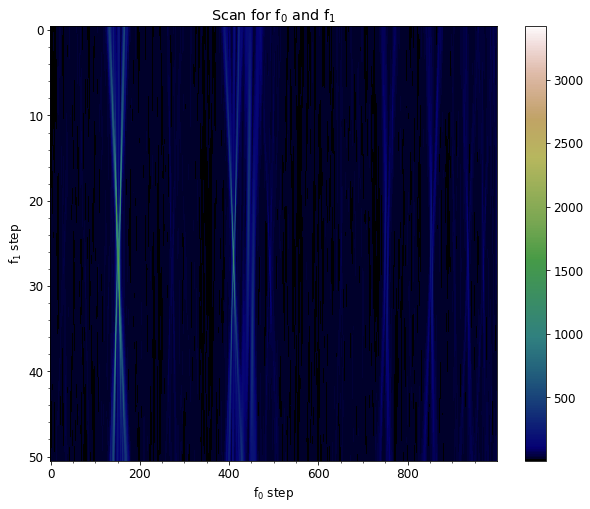

In [13]:
#plot the scan of f0,f1
plt.rc('font',size=12)
plt.figure(figsize=(10,8))
plt.title("Scan for f$_0$ and f$_1$")
plt.xlabel("f$_0$ step")
plt.ylabel("f$_1$ step")
plt.minorticks_on()

plt.imshow(x, cmap='gist_earth', aspect='auto')
plt.colorbar()
plt.show()

[Text(1, 1.0, '1'), Text(1, 3.0, '3'), Text(1, 6.0, '6')]

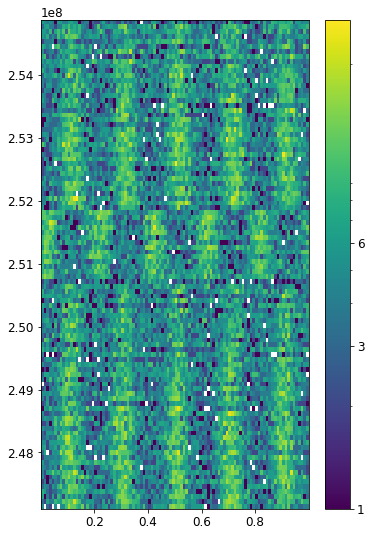

In [21]:
#calculate the phases of photons using optimal parameters
time = data_time[(evt_data['ENERGY']<1e3) & (evt_data['ENERGY']>0.3e3)]

phase_final = Phi(f0_list[index_max], f1_list[index_max], data_time)

phase_double = np.concatenate((phase_final, 1+phase_final))
time_double = np.concatenate((data_time, data_time))

plt.rc('font',size=12)
plt.figure(figsize=(6,9))


NBINS = (100, 100)
img_zero_mpl = plt.hist2d(phase_final, data_time, NBINS,
                          cmap='viridis', norm=LogNorm())

#Here we can see a source at the center and some other sources on the border

cbar = plt.colorbar(ticks=[1.0,3.0,6.0])
cbar.ax.set_yticklabels(['1','3','6'])

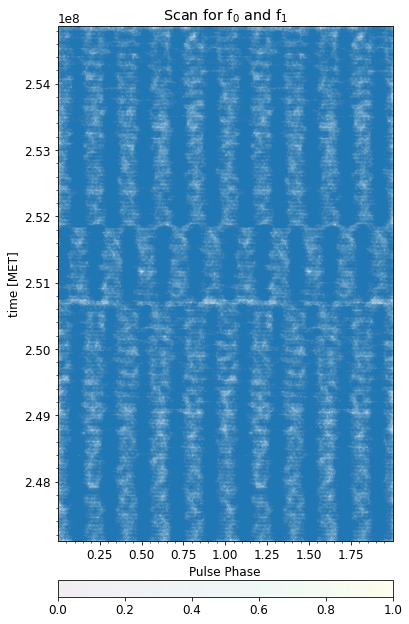

In [22]:
#-------------------------SCATTER PLOT-------------------------
plt.rc('font',size=12)
plt.figure(figsize=(6,12))
plt.title("Scan for f$_0$ and f$_1$")
plt.xlabel('Pulse Phase')
plt.ylabel("time [MET]")
plt.xlim(min(phase_double),max(phase_double))
plt.ylim(min(data_time),max(data_time))
plt.minorticks_on()

plt.scatter(phase_double, time_double, alpha=0.07,
            cmap='viridis')

plt.colorbar(orientation='horizontal',pad=0.06)

#savefig dpi=300

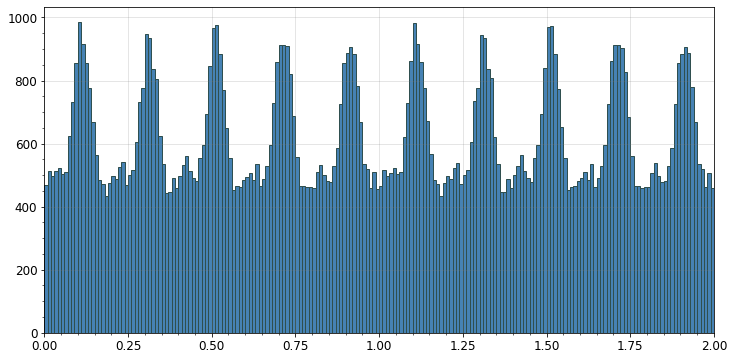

In [23]:
#-------------------FIRST PHASOGRAM-----------------------------

#duplicate the data of phases
phase_double = np.concatenate((phase_final, 1+phase_final)) 

#let's see histogram
plt.rc('font',size=12)
plt.figure(figsize=(12,6))
plt.grid(b=True, color='grey', linestyle='-', alpha=0.25)
plt.xlim(0,2)
plt.minorticks_on()

phase_count = plt.hist(phase_double, bins = 200,facecolor = 'steelblue', edgecolor='darkslategray')
